In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl1path = workDir+'CV3_data/LVL1/'
lvl2path = workDir+'CV3_data/LVL2/'

analyze_ramp = 1

infile = 'NonLinearityCorrection_OutputParameters_dic_CV3_MRS_RAD_14_IntegrationRamp{}'.format(analyze_ramp)
out_parameters_dic = funcs.load_obj(infile,path='obj/')

save_result = True

<IPython.core.display.Javascript object>


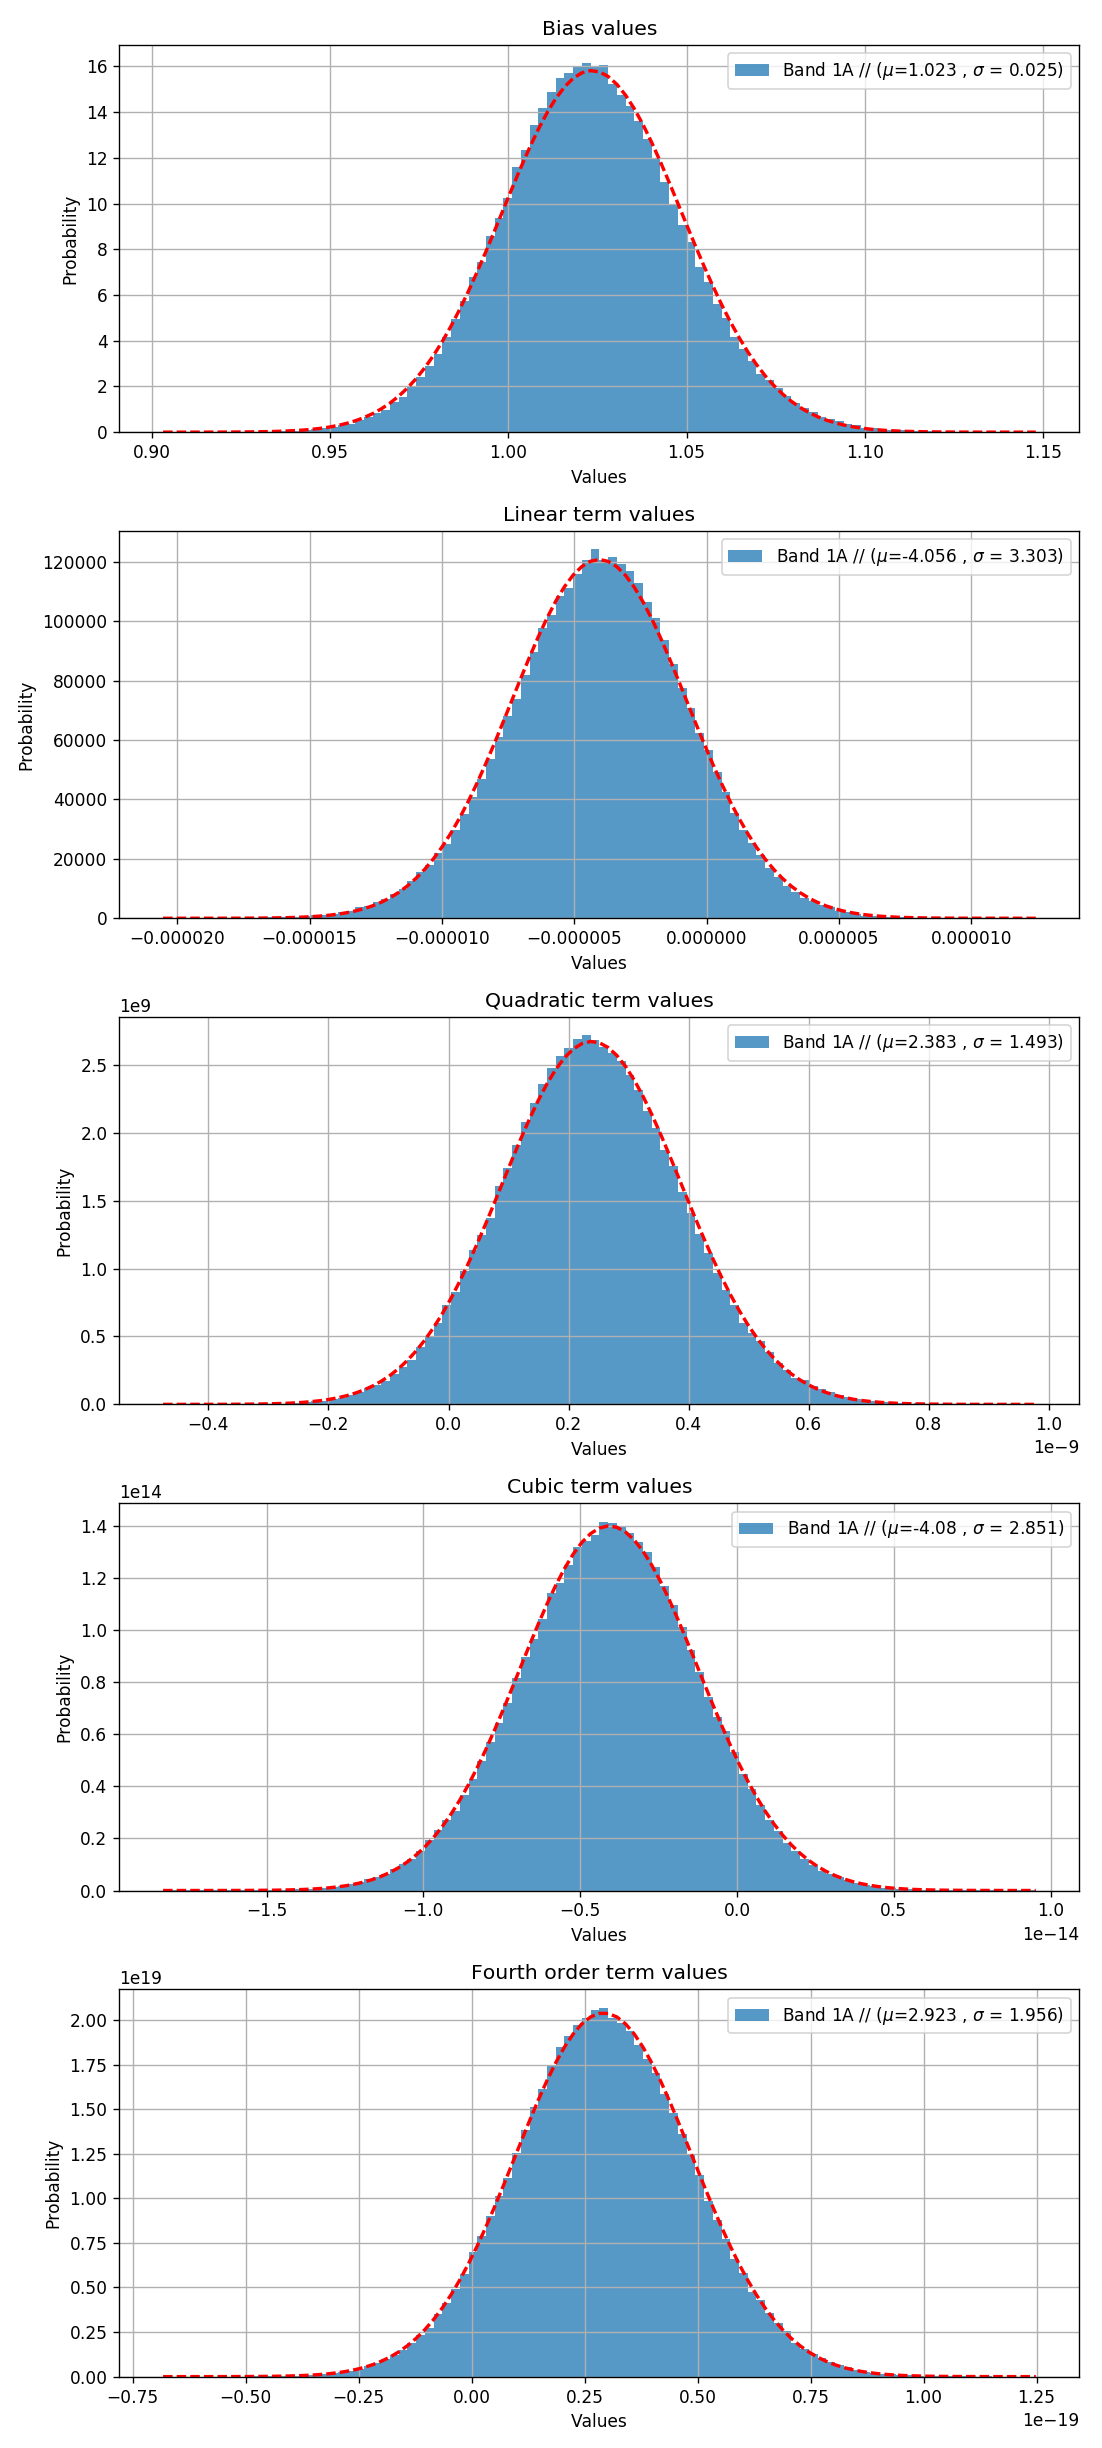

In [3]:
plt.close('all')
parameters =  {'0':'Bias','1':'Linear term','2':'Quadratic term','3':'Cubic term','4':'Fourth order term'}
parameter_range = {'0':[0.8,1.2],'1':[-30*1e-6,30*1e-6],'2':[-5*1e-10,10*1e-10],'3':[-15*1e-15,15*1e-15],'4':[-7*1e-20,10*1e-20]}
scale_factor = {'0':1,'1':10**6,'2':10**10,'3':10**15,'4':10**20}

best_parameters,best_parameters_err = {},{}
mean,error = {},{}

fig,axs = plt.subplots(5,1,figsize=(9,20))
for band in ['1A']: # ['1A','1B','1C','2A','2B','2C','3A','3B','3C']
    out_parameters = out_parameters_dic[band]
    best_parameters[band] = np.zeros(out_parameters.shape)
    best_parameters_err[band] = np.zeros(out_parameters.shape)
    mean[band],error[band] = np.zeros(out_parameters.shape[0]),np.zeros(out_parameters.shape[0])
    
    d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
    sel = (d2cMaps['sliceMap'] > 100*int(band[0])) & (d2cMaps['sliceMap'] < 100*(int(band[0])+1) )
    
    for parameter in range(5):
        (mu, sigma) = norm.fit(out_parameters[parameter,:,:][sel][(out_parameters[parameter,:,:][sel] > parameter_range[str(parameter)][0]) & (out_parameters[parameter,:,:][sel] < parameter_range[str(parameter)][1])])
    
        n, bins, patches = axs[parameter].hist(out_parameters[parameter,:,:][sel][(out_parameters[parameter,:,:][sel] > mu-5*sigma) & (out_parameters[parameter,:,:][sel] < mu+5*sigma)], 100, normed=1, alpha=0.75,label=r'Band {} // ($\mu$={} , $\sigma$ = {})'.format(band,round(mu*scale_factor[str(parameter)],3), round(sigma*scale_factor[str(parameter)],3) ))
        y = mlab.normpdf(bins, mu, sigma)
        if band[0] in ['1','2']:
            axs[parameter].plot(bins, y, 'r--', linewidth=2)
        elif band[0] in ['3']:
            axs[parameter].plot(bins, y, 'k--', linewidth=2)

        if save_result:
            if band[0] == '1':
                best_parameters[band][parameter,:,:516] = mu
                best_parameters_err[band][parameter,:,:516] = sigma
            elif band[0] in ['2','3']:
                best_parameters[band][parameter,:,516:] = mu
                best_parameters_err[band][parameter,:,516:] = sigma
                
            mean[band][parameter] = mu
            error[band][parameter] = sigma
        
for plot in range(5):
    axs[plot].set_xlabel('Values')
    axs[plot].set_ylabel('Probability')
    axs[plot].set_title('{} values'.format(parameters[str(plot)]))
    axs[plot].legend()
    axs[plot].grid(True)
plt.tight_layout()

## > Channel 4
Due to the pull-up pull-down effect, the non-linearity parameters in channel 4 are incorrect. We replace these with the mean value of the non-linearity parameters of channel 3 (since CH3 and CH4 fall on the same detector).

In [35]:
for band in ['4A','4B','4C']:
    best_parameters[band],best_parameters_err[band] = np.zeros(out_parameters.shape), np.zeros(out_parameters.shape)
    mean[band],error[band] = np.zeros(out_parameters.shape[0]),np.zeros(out_parameters.shape[0])
    
    for parameter in range(5):
        mean[band][parameter] = (mean['3A'][parameter]+mean['3B'][parameter]+mean['3C'][parameter])/3.
        error[band][parameter] = np.sqrt(error['3A'][parameter]**2. + error['3B'][parameter]**2. + error['3C'][parameter]**2.)/3.
    
        best_parameters[band][parameter,:,:516] = mean[band][parameter]
        best_parameters_err[band][parameter,:,:516] = error[band][parameter]

<IPython.core.display.Javascript object>


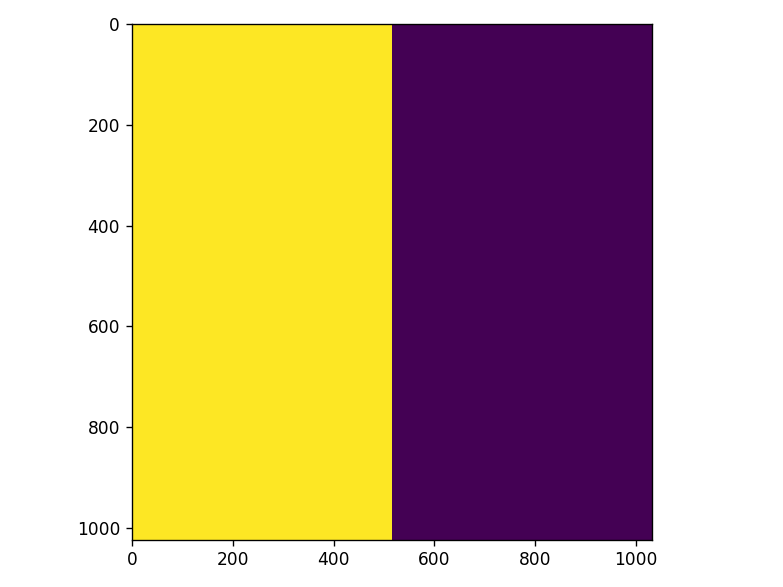

In [37]:
plt.figure()
plt.imshow(best_parameters['4A'][0,:,:])
plt.tight_layout()

In [58]:
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print mean[band]
#     print error[band]

[ 1.01447670e+00 -2.62037236e-06  1.61717354e-10 -2.55943765e-15
  1.89042782e-20]
[ 1.01548901e+00 -2.69544700e-06  1.61175544e-10 -2.57779172e-15
  1.91921134e-20]
[ 1.01896248e+00 -3.07519908e-06  1.76088751e-10 -2.82707140e-15
  2.09519873e-20]
[ 1.02152374e+00 -3.29576854e-06  1.81372008e-10 -2.88388172e-15
  2.08408712e-20]
[ 1.02106831e+00 -3.23017886e-06  1.76566466e-10 -2.82459694e-15
  2.06856107e-20]
[ 1.01800657e+00 -2.96779538e-06  1.70959247e-10 -2.74699352e-15
  2.03067221e-20]
[ 1.03026664e+00 -4.68492125e-06  2.48405293e-10 -3.78575766e-15
  2.65989539e-20]
[ 1.02842251e+00 -4.45533625e-06  2.41668671e-10 -3.86353604e-15
  2.72017877e-20]
[ 1.02893189e+00 -4.68500360e-06  2.58858064e-10 -4.19578770e-15
  3.03096035e-20]
[ 1.02920702e+00 -4.60842037e-06  2.49644009e-10 -3.94836047e-15
  2.80367817e-20]
[ 1.02920702e+00 -4.60842037e-06  2.49644009e-10 -3.94836047e-15
  2.80367817e-20]
[ 1.02920702e+00 -4.60842037e-06  2.49644009e-10 -3.94836047e-15
  2.80367817e-20]


<IPython.core.display.Javascript object>


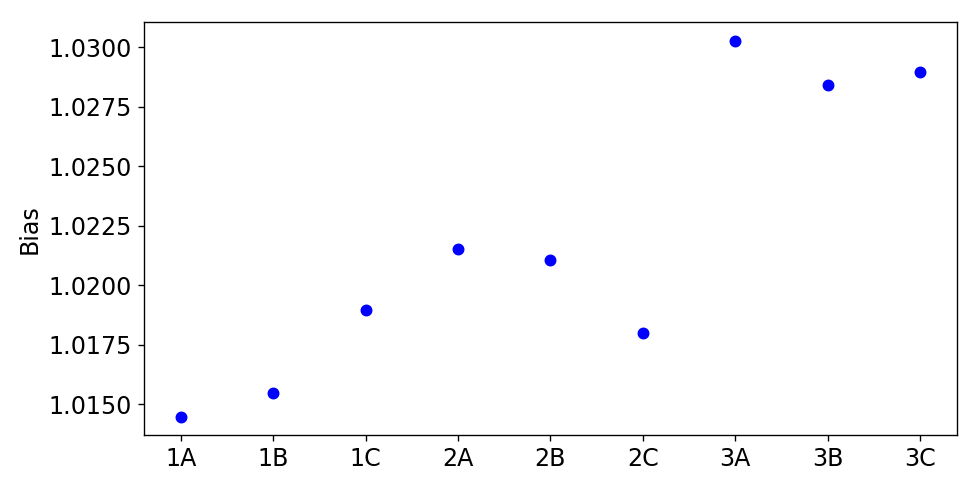

<IPython.core.display.Javascript object>


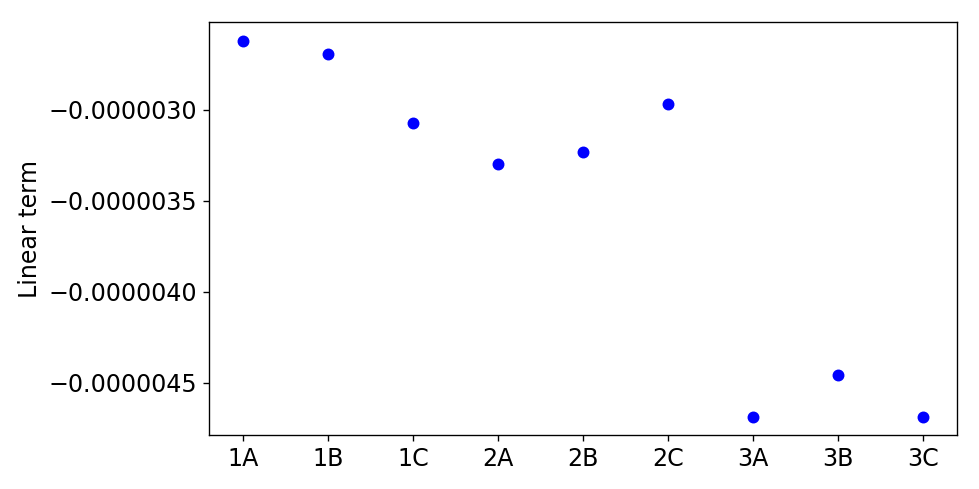

<IPython.core.display.Javascript object>


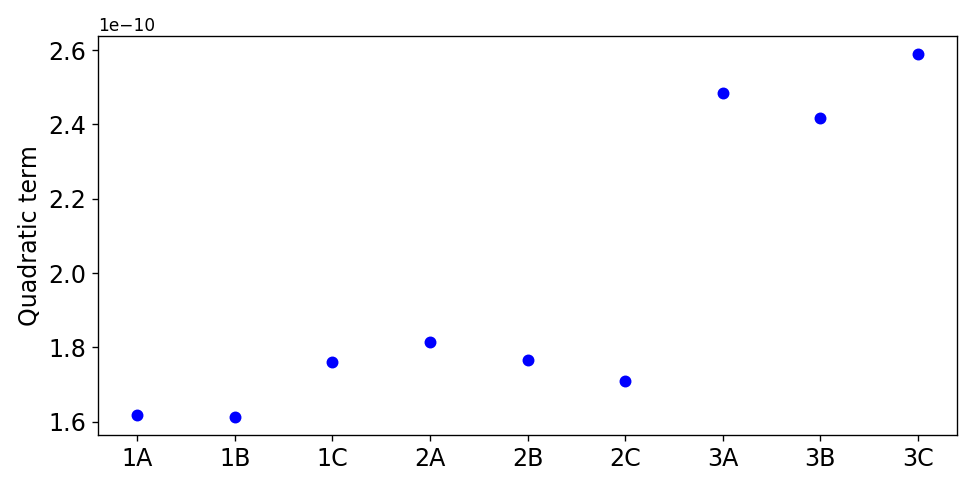

<IPython.core.display.Javascript object>


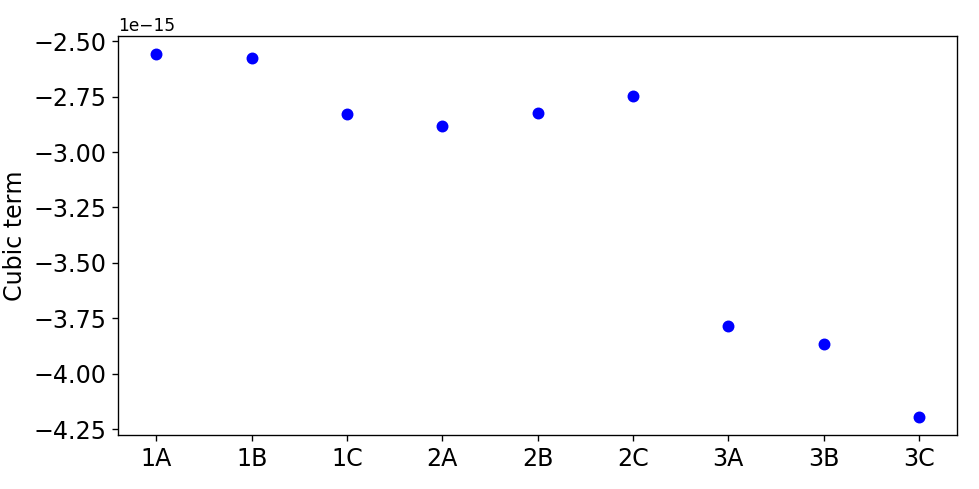

<IPython.core.display.Javascript object>


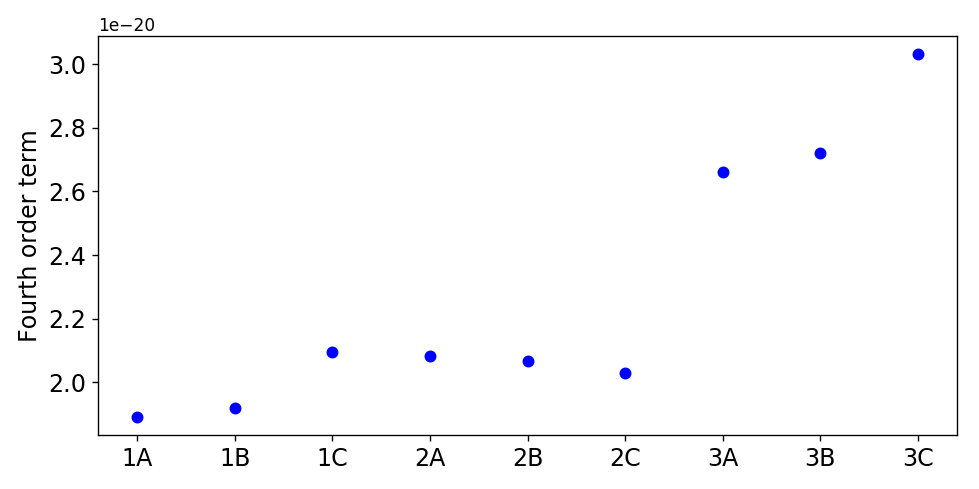

In [27]:
plt.close('all')
bands = ['test','1A','1B','1C','2A','2B','2C','3A','3B','3C']
for parameter in range(5):
    fig,axs = plt.subplots(1,1,figsize=(8,4))
    for i,band in enumerate(['1A','1B','1C','2A','2B','2C','3A','3B','3C']):
        axs.plot(i,mean[band][parameter],'bo')
    axs.set_xticklabels(bands)
    axs.set_ylabel(parameters[str(parameter)],fontsize=14)
    axs.tick_params(axis='both',labelsize=14)
    plt.tight_layout()
    plt.savefig(parameters[str(parameter)]+'.png')

In [43]:
outfile = 'NonLinearityCorrection_OutputParameters_BestModel_dic_CV3_MRS_RAD_14'
funcs.save_obj(best_parameters,outfile,path='obj/')

outfile_err = 'NonLinearityCorrection_OutputParameters_BestModelError_dic_CV3_MRS_RAD_14'
funcs.save_obj(best_parameters_err,outfile_err,path='obj/')